# VAE for brainwave classification

In this notebook, we train a VAE using datasets taken from four subjects in three different states: neutral, concentrating, and relaxing. The raw datsets were obtained from https://github.com/jordan-bird/eeg-feature-generation/tree/master/dataset/original_data

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data preprocessing

We load in the dataset of extracted features. Each row of the dataset contains all the feature vectors extracted per time slice. Each row is then reshaped to a 12x12 image.

(2247, 145)


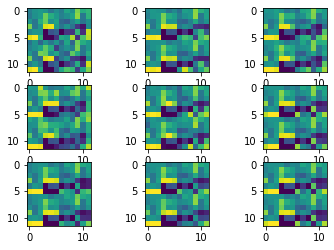

(1797, 12, 12, 1)


In [3]:
matrix_data = pd.read_csv('/content/gdrive/MyDrive/testFeat.csv', error_bad_lines=False)
print(matrix_data.shape)
labels = matrix_data['Label']
matrix = matrix_data.iloc[:,:-1]

min_max_scaler = preprocessing.MinMaxScaler()
matrix = min_max_scaler.fit_transform(matrix)
X_train, X_test, y_train, y_test = train_test_split(matrix, labels, test_size=0.2, shuffle=True, random_state=8)

# Reshape each row as a 12 x 12 image
def reshape_to_12(data):
    new_arr = np.zeros((12,12))
    for i in range(data.shape[0]):
        if (i > 0):
            row_data = np.reshape(data[i,:], (12,12))
            new_arr = np.dstack((new_arr, row_data))
        else: 
            new_arr = np.reshape(data[0,:], (12,12))
    return new_arr
x_train = reshape_to_12(X_train)
x_test = reshape_to_12(X_test)

x_train = np.asarray(np.moveaxis(x_train, -1, 0)).astype('float32').round(decimals=4)
x_test = np.asarray(np.moveaxis(x_test, -1, 0)).astype('float32').round(decimals=4)
y_train = np.asarray(y_train).astype(np.int64).reshape((-1,1))
y_test = np.asarray(y_test).astype(np.int64).reshape((-1,1))

label_dict = {
 0: 'relaxed',
 1: 'neutral',
 2: 'concentrating'
}

# Checking min max within [0,1]
np.max(x_train), np.min(x_test)

# Plotting some images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[random.randrange(0, 450), :,:])
plt.show()

x_train = x_train.reshape(-1, 12, 12, 1)
x_test = x_test.reshape(-1, 12, 12, 1)
print(x_train.shape)

In [4]:
# Splitting the data for training and validation
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=10)

# Creating VAE

Base VAE from https://keras.io/examples/generative/vae/

In [5]:
# Parameters
batch_size = 32
epochs = 800
num_classes = 3
latent_dim = 2
input_img = Input(shape = (12, 12, 1))

##### Create sampling layer

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

##### Building the encoder

In [7]:
encoder_inputs = keras.Input(shape=(12, 12, 1))
x = layers.Conv2D(32, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(encoder_inputs)
#x = BatchNormalization()(x)
x = layers.Conv2D(64, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(x)
#x = BatchNormalization()(x)      

# Latent space / bottleneck layer  
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 6, 6, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 576)          0           conv2d_1[0][0]                   
____________________________________________________________________________________________

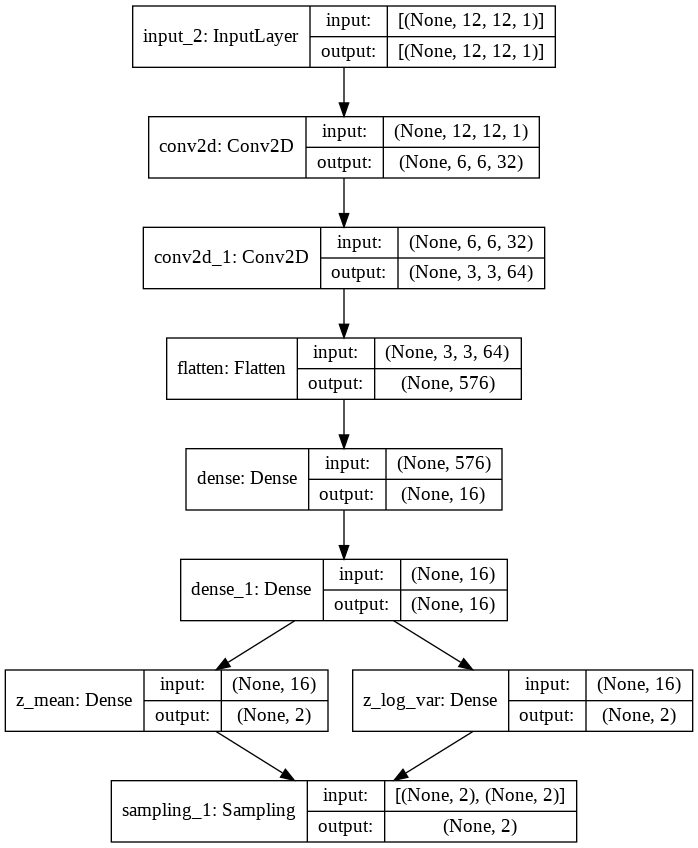

In [8]:
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
enc_file = '/content/gdrive/MyDrive/enc_model.png'
tf.keras.utils.plot_model(encoder, to_file=enc_file, show_shapes=True)

##### Building the decoder

In [9]:
encoder_inputs = keras.Input(shape=(12, 12, 1))
x = layers.Conv2D(32, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(encoder_inputs)
#x = BatchNormalization()(x)
x = layers.Conv2D(64, 3, 
                  activation="relu", 
                  strides=2, 
                  padding="same")(x)
#x = BatchNormalization()(x)      

# Latent space //bottleneck layer  
x = layers.Flatten()(x)

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3 * 3 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((3, 3, 64))(x)
x = layers.Conv2DTranspose(64, 3, 
                           activation="relu", 
                           strides=2, 
                           padding="same")(x)
x = BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, 
                           activation="relu", 
                           strides=2, 
                           padding="same")(x)
x = BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
dec_file = '/content/gdrive/MyDrive/dec_model.png'
tf.keras.utils.plot_model(decoder, to_file=dec_file, show_shapes=True)
encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 12, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 6, 6, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 576)          0           conv2d_1[0][0]                   
____________________________________________________________________________________________

##### Defining the VAE as a Model

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    #keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    keras.losses.mse(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            #total_loss = reconstruction_loss + kl_loss
            total_loss = K.mean(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Training the VAE

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))
vae.fit(x_train, epochs=800, batch_size=batch_size, shuffle=True)

Epoch 1/800
57/57 [==============================] - 2s 15ms/step - loss: 272.4872 - reconstruction_loss: 204.1736 - kl_loss: 6.1829
Epoch 2/800
57/57 [==============================] - 1s 15ms/step - loss: 52.0653 - reconstruction_loss: 38.0773 - kl_loss: 7.6296
Epoch 3/800
57/57 [==============================] - 1s 15ms/step - loss: 39.1829 - reconstruction_loss: 34.0027 - kl_loss: 3.8597
Epoch 4/800
57/57 [==============================] - 1s 15ms/step - loss: 36.6010 - reconstruction_loss: 32.9382 - kl_loss: 2.9800
Epoch 5/800
57/57 [==============================] - 1s 15ms/step - loss: 35.7020 - reconstruction_loss: 31.9709 - kl_loss: 2.6884
Epoch 6/800
57/57 [==============================] - 1s 15ms/step - loss: 32.8981 - reconstruction_loss: 30.9369 - kl_loss: 2.5432
Epoch 7/800
57/57 [==============================] - 1s 15ms/step - loss: 32.2170 - reconstruction_loss: 30.0786 - kl_loss: 2.4354
Epoch 8/800
57/57 [==============================] - 1s 15ms/step - loss: 32.6672

# Results

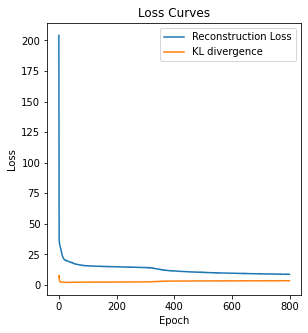

In [12]:
# Plotting the loss curves
plt.figure(figsize=[10,5])
plt.subplot(122)
plt.plot(vae.history.history['reconstruction_loss'])
plt.plot(vae.history.history['kl_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Reconstruction Loss','KL divergence'])
plt.title('Loss Curves')
plt.show()

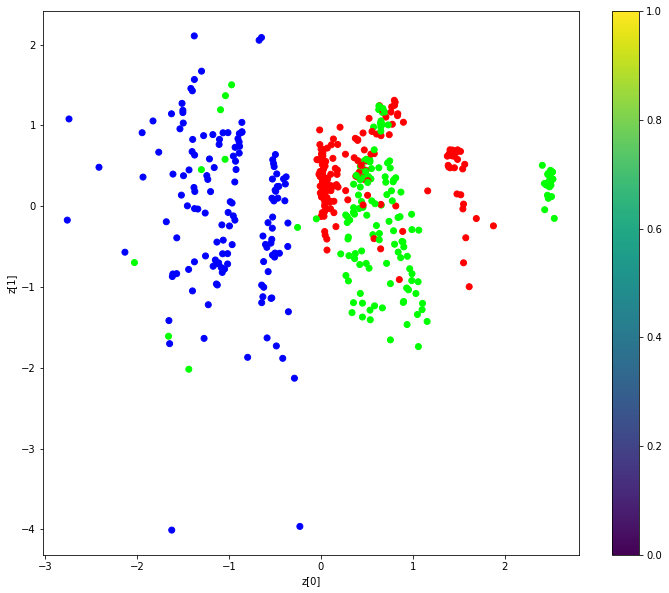

In [13]:
# One-hot encoding the labels
y_train_OH = to_categorical(y_train)
y_test_OH = to_categorical(y_test)

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_test, y_test_OH  )

##### Saving the trained model

In [14]:
# Saving the model
vae.save_weights('trained_vae')

In [15]:
# Restoring the weights
trained_vae = VAE(encoder, decoder)
trained_vae.load_weights(filepath='/content/trained_vae')
trained_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

#plot_label_clusters(trained_vae, x_test, y_test)

##### Get latent vector for one time slice and write to parameters to file


In [ ]:
sc_val = 'sc-input.txt'

def write_sc_params_to_file(matrix, labels, encoder):
    with open(sc_val, "w+") as f:
        data = f.read()
        f.seek(0)
        i = 0
        while i < len(matrix):
            # Take the latent vector from each time slice
            curr_img = matrix[i, :, :]
            curr_img = np.expand_dims(curr_img, axis=0)
            lat_vec = encoder.predict(curr_img)
            
            label = round(int(labels[i]))
            freq, mul = calc_params(lat_vec)

            f.write(str(freq) + '\n')
            f.write(str(mul) + '\n')
            f.write(str(label) + '\n')
            f.truncate()

            i += 1

def calc_params(vec):
    vec = (np.array(vec).T).flatten().reshape(2,3)
    vec1 = vec[0,:]
    vec2 = vec[1,:]
    mean1 = np.mean(vec1)
    mean2 = np.mean(vec2)
    
    # Normalise frequency to range 0-800
    freq = ((mean1 - vec1.min()) * (800)) / (vec1.max() - vec1.min()) #+ 100
    # Normalise mul to range 0-4
    mul = ((mean2 - vec2.min()) * (4)) / (vec2.max() - vec2.min())
    
    return round(freq), round(mul, 1)

sorted_matrix = matrix_data.sort_values(by=['Label'])
labels_sorted = sorted_matrix['Label']
sorted_matrix = min_max_scaler.fit_transform(sorted_matrix)
#matrix = matrix.iloc[:,:-1]
matrix = np.delete(sorted_matrix, np.s_[-1:], axis=1)
print(matrix.shape)
matrix = reshape_to_12(matrix)
matrix = np.asarray(np.moveaxis(matrix, -1, 0)).astype('float32').round(decimals=4)
labels = np.asarray(labels_sorted).astype(np.int64).reshape((-1,1))
write_sc_params_to_file(matrix, labels, encoder)

(2247, 144)
